In [ ]:
# !nvidia-smi
# !pip install gdown
# !pip install tensorflow_text
# !pip install wordcloud
# !pip install tensorflow-gpu
# !pip install "tensorflow_hub>=0.6.0"
# !pip install "tensorflow>=2.0.0"

import os
import random
import re
import string
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from spacy.util import compounding
from spacy.util import minibatch
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
PATH = '/content/drive/My Drive/Analysis/'
train = pd.read_csv(PATH + 'dataset/train.csv')
test = pd.read_csv(PATH + 'dataset/test.csv')
print(train.shape)
print(test.shape)

(3235, 6)
(1387, 5)


In [ ]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3235 non-null   float64
 1   original_text    3235 non-null   object 
 2   lang             3231 non-null   object 
 3   retweet_count    3231 non-null   object 
 4   original_author  3235 non-null   object 
 5   sentiment_class  3235 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 151.8+ KB


In [ ]:
train.dropna(inplace=True)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387 entries, 0 to 1386
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1387 non-null   float64
 1   original_text    1387 non-null   object 
 2   lang             1387 non-null   object 
 3   retweet_count    1386 non-null   object 
 4   original_author  1387 non-null   object 
dtypes: float64(1), object(4)
memory usage: 54.3+ KB


In [ ]:
train.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


In [ ]:
temp = train.groupby('sentiment_class').count()['original_text'].reset_index().sort_values(by='original_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment_class,original_text
1,0,1693
0,-1,769
2,1,765


In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment_class,
    values = temp.original_text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [ ]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = text.replace('’','\'')
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('instagram.*', '', text)
    text = re.sub('piccom.*', '', text)
    text = re.sub('https|…|twitter|#|@|“|”|°', '', text)
    text = re.sub('mothers|day|happy|mothersday', '', text)
    text_list = remove_stopword(str(text).split())    
    return ' '.join(text_list)

In [ ]:
train['cleaned_text'] = train['original_text'].apply(lambda x:clean_text(x))

# Observations and Diagrams

In [ ]:
train['temp_list'] = train['cleaned_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,mothers,3972
1,day,3727
2,happy,3429
3,mothersday,1603
4,love,925
5,mum,891
6,mums,783
7,today,526
8,mother,446
9,us,390


In [ ]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [ ]:
positive_sent = train[train['sentiment_class'] == 1]
negative_sent = train[train['sentiment_class'] == -1]
neutral_sent = train[train['sentiment_class'] == 0]

In [ ]:
# Most common positive words
top = Counter([item for sublist in positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,mothers,953
1,day,870
2,happy,808
3,mothersday,378
4,love,214
5,mum,214
6,mums,179
7,today,119
8,mother,106
9,us,94


In [ ]:
# Most common negative words
top = Counter([item for sublist in negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,day,860
2,happy,808
3,mothersday,376
4,love,250
5,mum,227
6,mums,193
7,today,121
8,mother,109
9,us,104
10,hope,74


In [ ]:
# Most common Neutral words
top = Counter([item for sublist in neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,1997
2,happy,1813
3,mothersday,849
4,love,461
5,mum,450
6,mums,411
7,today,286
8,mother,231
9,us,192
10,amazing,176


In [ ]:
raw_text = [word for word_list in train['temp_list'] for word in word_list]

In [ ]:
def words_unique(sentiment, numwords, raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment_class != sentiment]['temp_list']:
        for word in item:
            allother.append(word)
    allother = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment_class == sentiment]['temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return unique_words

In [ ]:
unique_Positive= words_unique(1, 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,black,6
1,​,4
2,active,4
3,loose,3
4,lying,3
5,carole,3
6,vintage,3
7,sculpture,3
8,nursing,3
9,kindly,3


In [ ]:
unique_Positive= words_unique(-1, 20, raw_text)
print("The top 20 unique words in Negative Tweets are:")
unique_Positive.style.background_gradient(cmap='Reds')

The top 20 unique words in Negative Tweets are:


,words,count
0,du,6
1,⁣⁣⁠⁣,4
2,village,4
3,⁣⁣⁠,3
4,rice,3
5,coz,3
6,donegal,3
7,disney,3
8,personal,3
9,mami,3


In [ ]:
unique_Positive= words_unique(0, 20, raw_text)
print("The top 20 unique words in Neutral Tweets are:")
unique_Positive.style.background_gradient(cmap='Blues')

The top 20 unique words in Neutral Tweets are:


,words,count
0,connected,9
1,r,8
2,front,8
3,aspiring,8
4,society,7
5,clients,7
6,watched,6
7,stayhomestaysafe,6
8,amongst,5
9,centre,5


In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(6.0, 6.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=100, 
                    height=100,
                    scale=10)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

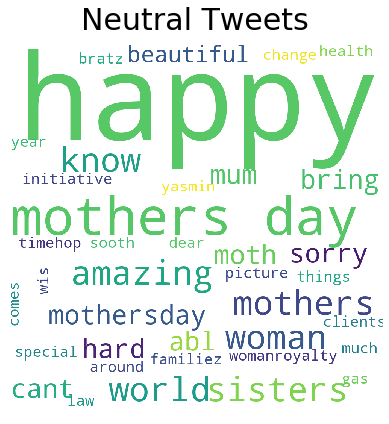

In [ ]:
plot_wordcloud(neutral_sent.cleaned_text, mask=pos_mask, title_size=30, title="Neutral Tweets")

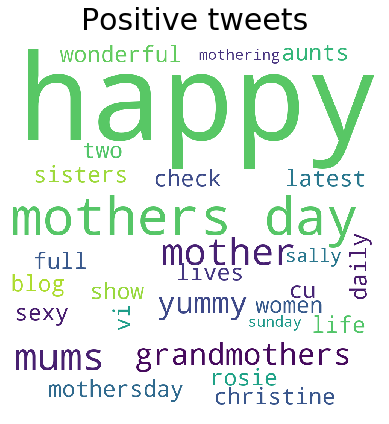

In [ ]:
plot_wordcloud(positive_sent.cleaned_text, mask=pos_mask, title="Positive tweets", title_size=30)

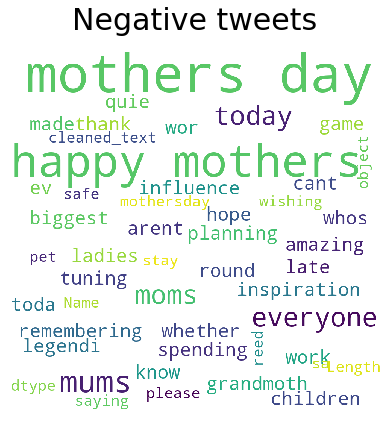

In [ ]:
plot_wordcloud(negative_sent.cleaned_text, mask=pos_mask, title="Negative tweets", title_size=30)

# Modelling

In [ ]:
# Important Cols cleaned_text and sentiment_class
# Need to use it for test too
train_df = train[['cleaned_text', 'sentiment_class']]
train_df.head()

,cleaned_text,sentiment_class
0,amazing know hard able see us protect vulnerab...,0
1,mum im sorry cant bring flowers cwtch honestly...,0
2,work quiet time reflect dog walk finish jigsaw...,-1
3,beautiful womanroyalty soothes mummy jeremy em...,0
4,remembering amazing ladies made late grandmoth...,-1


In [ ]:
test['cleaned_text'] = test['original_text'].apply(lambda x:clean_text(x))
test_df = test[['id', 'cleaned_text']]
test_df.head()

,id,cleaned_text
0,1.246628e+18,yeah cooked potatoes years old mean threw bag ...
1,1.245898e+18,mums stepmums grand dads cover parental roles ...
2,1.244717e+18,love people uk however awoke saw trending woke...
3,1.245730e+18,birth mum cant see keep safe shame many others...
4,1.244636e+18,wonderful world live present always rely mothe...


In [ ]:
type_one_hot = OneHotEncoder(sparse=False).fit_transform(
    train_df.sentiment_class.to_numpy().reshape(-1, 1)
)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(train_df.cleaned_text,
                                                    type_one_hot,
                                                    test_size=.1,
                                                    random_state=1
                                                  )

# Modelling 1: Embedding Pre Lookup Model

In [ ]:
module_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
embed = hub.KerasLayer(module_url)
embeddings = embed(["A long sentence.", "single-word",
                    "http://example.com"])
print(embeddings.shape)  #(3,128)

In [ ]:
train_X = []

for sentence in tqdm(train_x):
  emb = embed([sentence])
  sentence_embedding = tf.reshape(emb, [-1]).numpy()
  train_X.append(sentence_embedding)

train_X = np.array(train_X)

100%|██████████| 2911/2911 [00:02<00:00, 1090.09it/s]


In [ ]:
test_X = []

for sentence in tqdm(test_x):
  emb = embed([sentence])
  sentence_embedding = tf.reshape(emb, [-1]).numpy()
  test_X.append(sentence_embedding)

test_X = np.array(test_X)

100%|██████████| 324/324 [00:00<00:00, 1088.92it/s]


In [ ]:
model = keras.Sequential()
# model.add(hub_layer)
model.add(keras.layers.Dense(units=256, input_shape=(train_X.shape[1],), 
                             activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_X, train_y, epochs=100, batch_size=4, 
                    validation_split=0.1, 
                    verbose=1, 
                    shuffle=True)

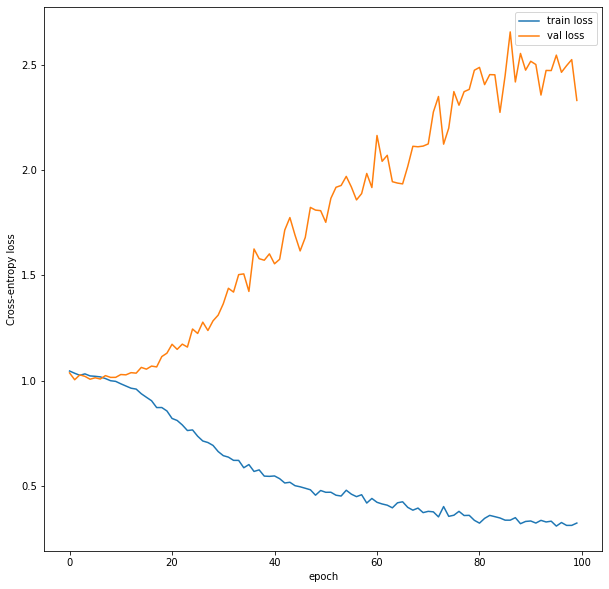

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

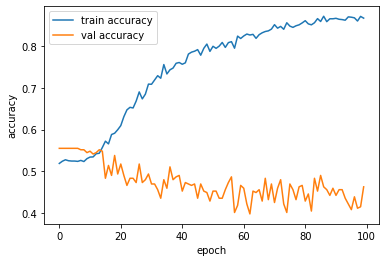

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
model.evaluate(test_X, test_y)

11/11 [==============================] - 0s 1ms/step - loss: 2.9673 - accuracy: 0.4444


[2.967316150665283, 0.4444444477558136]

# Modelling 2: Embedding Layer Model


In [ ]:
train_x, test_x, train_y, test_y = train_test_split(train_df.cleaned_text,
                                                    type_one_hot,
                                                    test_size=.1,
                                                    random_state=1
                                                  )

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", output_shape=[128],
                           input_shape=[], dtype=tf.string)
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 195       
Total params: 124,651,139
Trainable params: 8,451
Non-trainable params: 124,642,688
_________________________________________________________________


In [ ]:
# input_text = tf.keras.Input((), dtype=tf.string, name='input_text')
# embedding = hub_layer(input_text)
embed([train_df['cleaned_text'][0]])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 0.19140953,  0.19943511,  0.02795447,  0.14277649,  0.06675703,
        -0.22592582,  0.15257737,  0.01113997, -0.02177524, -0.0204234 ,
        -0.13202837,  0.00165972,  0.06693799, -0.2561168 ,  0.21297517,
        -0.05325458, -0.02367662, -0.17761189, -0.06414608, -0.02169079,
         0.00933411,  0.07365692,  0.10530455,  0.02278584, -0.03877132,
        -0.31471723,  0.11946777,  0.3306818 , -0.0318742 , -0.05605437,
         0.0299108 ,  0.05090968,  0.20386484,  0.06150984,  0.24057205,
        -0.09016474, -0.2541646 , -0.00275669,  0.19382554, -0.01365957,
        -0.1495418 , -0.21498775, -0.10399609, -0.02398051, -0.00932805,
        -0.01196792, -0.04063909,  0.06410025,  0.20106676,  0.08038047,
         0.00984398, -0.00358324, -0.16204569,  0.08942051,  0.00294448,
        -0.0121595 , -0.01891474, -0.22219263,  0.023642  ,  0.03489816,
        -0.1047613 ,  0.2960454 ,  0.06307705, -0.08355895, -0.09318483,
 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=1, batch_size=16, 
                    validation_split=0.1, 
                    verbose=1, 
                    shuffle=True)

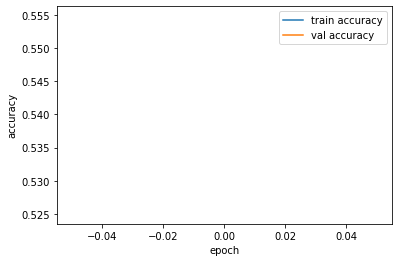

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
model.evaluate(test_x, test_y)

11/11 [==============================] - 2s 160ms/step - loss: 1.0372 - accuracy: 0.5093


[1.0371732711791992, 0.5092592835426331]

In [ ]:
predictions = model.predict(test_df['cleaned_text'])
class_preds = np.argmax(predictions, axis=1)
test_df['sentiment_class'] = class_preds
test_df[['id', 'sentiment_class']].to_csv('submission.csv', index=False)

[0.23998727 0.5277512  0.23226152]


(1387,)

# Modelling 3: Embedding + LSTM Model


In [ ]:
# Try Ensembling/ Two LSTM or GRU?

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", output_shape=[128],
                           input_shape=[], dtype=tf.string)
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Reshape(target_shape=(128, 1)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
reshape_2 (Reshape)          (None, 128, 1)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128, 128)          33792     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [ ]:
total_rows = [769, 1693, 765]
weight_rows = [1075/769, 1075/1693, 1075/765]
class_weight = {0: weight_rows[0], 1: weight_rows[1], 2: weight_rows[2]}

In [ ]:
METRICS = [      
      keras.metrics.CategoricalAccuracy(name='accuracy'),      
      keras.metrics.AUC(name='auc', multi_label=True),
]

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-4), 
              metrics=METRICS)

history = model.fit(train_x, train_y, epochs=100, batch_size=64, 
                    validation_split=0.1, 
                    verbose=1, 
                    shuffle=True,
                    class_weight=class_weight)

Epoch 1/100
41/41 [==============================] - 7s 172ms/step - loss: 1.0932 - accuracy: 0.3058 - auc: 0.5382 - val_loss: 1.1070 - val_accuracy: 0.2329 - val_auc: 0.4697
Epoch 2/100
41/41 [==============================] - 5s 126ms/step - loss: 1.0928 - accuracy: 0.3100 - auc: 0.5435 - val_loss: 1.1074 - val_accuracy: 0.2500 - val_auc: 0.4720
Epoch 3/100
41/41 [==============================] - 5s 125ms/step - loss: 1.0922 - accuracy: 0.3058 - auc: 0.5409 - val_loss: 1.1080 - val_accuracy: 0.2329 - val_auc: 0.4756
Epoch 4/100
41/41 [==============================] - 5s 125ms/step - loss: 1.0935 - accuracy: 0.2994 - auc: 0.5386 - val_loss: 1.1052 - val_accuracy: 0.2397 - val_auc: 0.4686
Epoch 5/100
41/41 [==============================] - 5s 124ms/step - loss: 1.0923 - accuracy: 0.3131 - auc: 0.5433 - val_loss: 1.1068 - val_accuracy: 0.2329 - val_auc: 0.4694
Epoch 6/100
41/41 [==============================] - 5s 124ms/step - loss: 1.0937 - accuracy: 0.3158 - auc: 0.5378 - val_loss

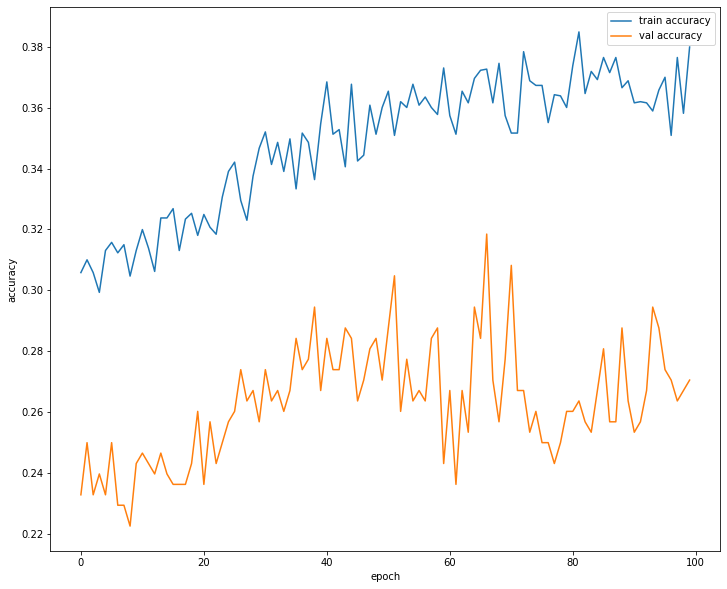

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
model.evaluate(test_x, test_y)

11/11 [==============================] - 1s 54ms/step - loss: 1.1299 - accuracy: 0.2593 - auc: 0.4310


[1.1299116611480713, 0.25925925374031067, 0.4309788644313812]

In [ ]:
predictions = model.predict(test_df['cleaned_text'])

In [ ]:
class_preds = np.argmax(predictions, axis=1)
class_preds = class_preds - 1
test_df['sentiment_class'] = class_preds
test_df[['id', 'sentiment_class']].to_csv('submission.csv', index=False)

In [ ]:
for x in class_preds:
  if x == 1:
    print("a")

# Modelling 4: Ensembling LSTM Networks

In [ ]:
sentiments = [-1, 0, 1]
one_vs_all = []

for sentiment in sentiments:    
  df = train_df[train_df['sentiment_class'] == sentiment]
  df['sentiment_class'] = 1
  sample_n = df.shape[0]
  negate_df = train_df[train_df['sentiment_class'] != sentiment]
  negate_df['sentiment_class'] = 0  
  negate_df_n = negate_df.sample(n=min(sample_n, len(negate_df)), random_state=1)  
  df = df.append(negate_df_n)
  df = df.sample(frac=1).reset_index(drop=True)
  one_vs_all.append(df)

for df in one_vs_all:
  print(df.shape)  

(1538, 2)
(3235, 2)
(1530, 2)


In [ ]:
METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),      
           keras.metrics.AUC(name='auc'),]

def make_model(metrics = METRICS, output_bias=None):
  hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1",
                            output_shape=[128],
                            input_shape=[], 
                             dtype=tf.string)
                             
  model = keras.Sequential()
  model.add(hub_layer)
  model.add(keras.layers.Reshape(target_shape=(128, 1)))
  model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
  model.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(rate=0.5))
  model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))

  model.compile(loss='binary_crossentropy', 
                optimizer=keras.optimizers.Adam(lr=1e-3), 
                metrics=METRICS)
  return model

In [ ]:
models = []
histories = []

for sentiment, train_df in zip(sentiments, one_vs_all):

  train_x, test_x, train_y, test_y = train_test_split(train_df.cleaned_text,
                                                      train_df.sentiment_class,
                                                      test_size=.1,
                                                      random_state=1)
  
  model = make_model()  

  print(f'Running model with sentiment class {sentiment}.')
  history = model.fit(train_x, train_y, epochs=50, batch_size=64, 
                    validation_split=0.1, 
                    verbose=1, 
                    shuffle=True)
  
  models.append(model)
  histories.append(history)
  print(model.evaluate(test_x, test_y))

Running model with sentiment class -1.
Epoch 1/50
20/20 [==============================] - 4s 209ms/step - loss: 0.7222 - accuracy: 0.4607 - auc: 0.4373 - val_loss: 0.6918 - val_accuracy: 0.5324 - val_auc: 0.4381
Epoch 2/50
20/20 [==============================] - 2s 117ms/step - loss: 0.6965 - accuracy: 0.4956 - auc: 0.5095 - val_loss: 0.6959 - val_accuracy: 0.4676 - val_auc: 0.4403
Epoch 3/50
20/20 [==============================] - 2s 117ms/step - loss: 0.6999 - accuracy: 0.5052 - auc: 0.4794 - val_loss: 0.6924 - val_accuracy: 0.5324 - val_auc: 0.4782
Epoch 4/50
20/20 [==============================] - 2s 118ms/step - loss: 0.6978 - accuracy: 0.5036 - auc: 0.4941 - val_loss: 0.6913 - val_accuracy: 0.5324 - val_auc: 0.4460
Epoch 5/50
20/20 [==============================] - 2s 117ms/step - loss: 0.6958 - accuracy: 0.4956 - auc: 0.5022 - val_loss: 0.6941 - val_accuracy: 0.4676 - val_auc: 0.4995
Epoch 6/50
20/20 [==============================] - 2s 118ms/step - loss: 0.6976 - accuracy

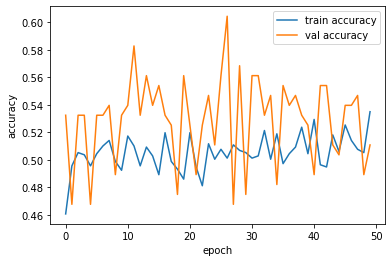

In [ ]:
for history in histories[0:1]:
  plt.plot(history.history['accuracy'], label='train accuracy')
  plt.plot(history.history['val_accuracy'], label='val accuracy')
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend();

In [ ]:
predictions_0 = models[0].predict(test_df['cleaned_text'])
predictions_1 = models[1].predict(test_df['cleaned_text'])
predictions_2 = models[2].predict(test_df['cleaned_text'])
predictions_all =  np.hstack((predictions_0, predictions_1, predictions_2)) 
class_preds = np.argmax(predictions_all, axis=1)
class_preds = class_preds - 1
test_df['sentiment_class'] = class_preds
test_df[['id', 'sentiment_class']].to_csv('submission.csv', index=False)